## Integrantes:
- Luis Francisco Rodriguez Acevedo

# Calibración de cámara

## Encontrar las propiedades intrínsecas y extrínsecas de una cámara

Se tomaron alrededor de 30 imagenes de un tablero de ajedrez en diferentes angulos y distancias

In [30]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 as cv
import glob

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/content/drive/MyDrive/Vision_computo/Clase10/Calibrar/*.jpg')

for fname in images:
    img = cv.imread(fname)
    img = cv.resize(img, (0,0), fx=0.2, fy=0.2)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Imprimir el nombre de la imagen
    print("Nombre de la imagen:", fname)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,10), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

    # Draw and display the corners
    cv.drawChessboardCorners(img, (7,10), corners2, ret)
    cv2_imshow(img)
    cv.waitKey(500)


Output hidden; open in https://colab.research.google.com to view.

## Calibracion

In [31]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)


[[6.43942137e+03 0.00000000e+00 4.19941756e+02]
 [0.00000000e+00 6.13423682e+02 2.20418700e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## Desdistorsión

Se utilizo pasando cada uno de las imagenes para eliminar la distorcion

In [32]:
img = cv.imread('/content/drive/MyDrive/Vision_computo/Clase10/Objeto2/Img_1.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

In [33]:
import cv2
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
# Filename
filename = '/content/drive/MyDrive/Vision_computo/Clase10/Objeto/Img_1.jpg'

# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, img)

True

## parámetros intrínsecos,

In [22]:
FX = 6.43942192e+03
FY = 6.13423741e+02
CX = 4.19941738e+02
CY = 2.20418727e+02

## Triangulación de puntos

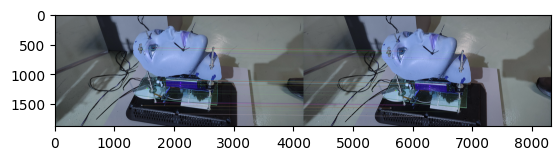

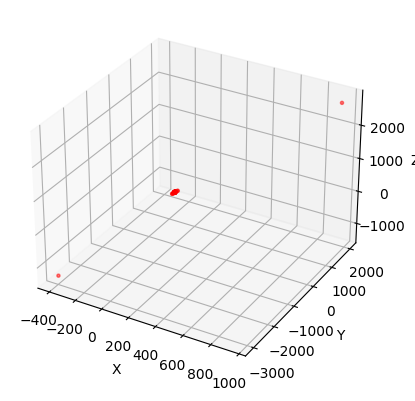

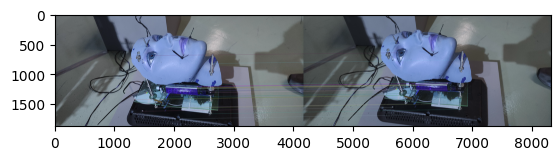

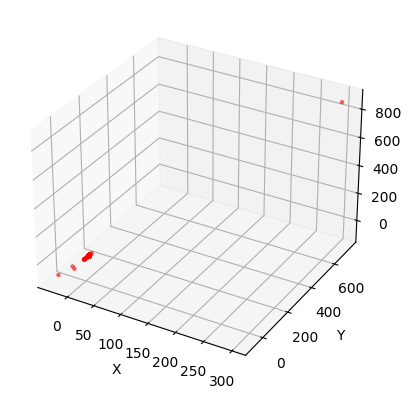

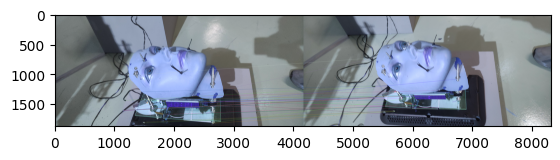

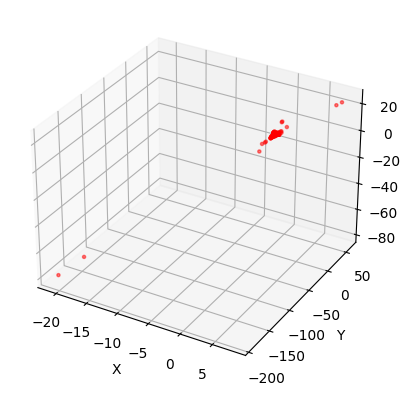

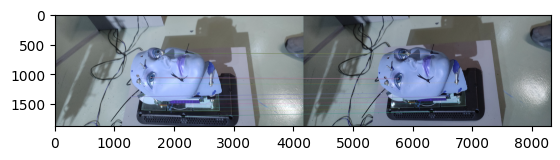

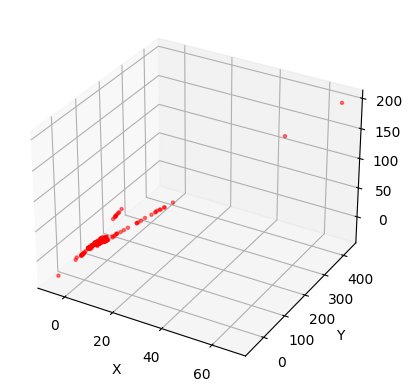

In [26]:
import matplotlib.pyplot as plt
import cv2
# Define la función para dibujar y mostrar los emparejamientos
def draw_matches(img1, kp1, img2, kp2, matches, num_matches=40):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches)
    plt.show()

# Lista para almacenar las coordenadas 3D de los puntos
coordenadas_puntos = []

# Realiza el proceso 4 veces (para 8 imágenes)
for i in range(1, 5):
    img1 = cv2.imread(f'/content/drive/MyDrive/Vision_computo/Clase10/Objeto2/Img_{2*i-1}.jpg')
    img2 = cv2.imread(f'/content/drive/MyDrive/Vision_computo/Clase10/Objeto2/Img_{2*i}.jpg')

    K = np.array([[FX, 0, CX], [0, FY, CY], [0, 0, 1]])  # Matriz intrínseca de la cámara

    # Detección y emparejamiento de características
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Mostrar los emparejamientos
    draw_matches(img1, kp1, img2, kp2, matches)

    # Matriz esencial
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

    # Triangulación de puntos
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    P1 = K @ P1
    P2 = K @ P2

    points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3D = points_4D / points_4D[3]  # Convertir de coordenadas homogéneas a Cartesianas
    points_3D = points_3D[:3, :].T

    coordenadas_puntos.append(points_3D)

    # Visualización
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

## Reconstruccion en 3D

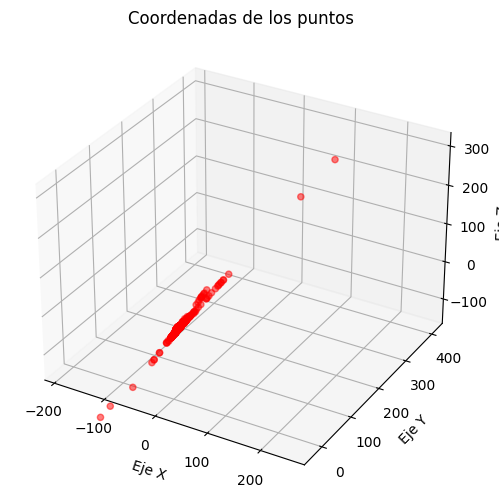

In [28]:
# Visualizar todos los puntos juntos
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre cada conjunto de puntos
for puntos in coordenadas_puntos:
    # Graficar los puntos
    ax.scatter(puntos[:, 0], puntos[:, 1], puntos[:, 2], marker='o', s=20, c='r', alpha=0.5)

# Configurar etiquetas y título
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
ax.set_title('Coordenadas de los puntos')

# Configurar la relación de aspecto para que los ejes tengan la misma escala
max_range = np.array([np.max(puntos[:,0])-np.min(puntos[:,0]), np.max(puntos[:,1])-np.min(puntos[:,1]), np.max(puntos[:,2])-np.min(puntos[:,2])]).max() / 2.0
mid_x = (np.max(puntos[:,0]) + np.min(puntos[:,0])) * 0.5
mid_y = (np.max(puntos[:,1]) + np.min(puntos[:,1])) * 0.5
mid_z = (np.max(puntos[:,2]) + np.min(puntos[:,2])) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Mostrar la gráfica
plt.show()